In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.makedirs("/content/drive/MyDrive/Filtered Fashion Images/Unzipped", exist_ok=True)

In [ ]:
!unzip -q "/content/drive/MyDrive/Filtered Fashion Images/Unzipped/dataset_split2-20250617T164602Z-1-002.zip" -d "/content/drive/MyDrive/Filtered Fashion Images/Unzipped"

In [ ]:
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks
output_base="/content/drive/MyDrive/Filtered Fashion Images/Unzipped/dataset_split2"
train_dir = os.path.join(output_base, 'train')
test_dir  = os.path.join(output_base, 'test')
IMG_SIZE = (224, 224)       # MobileNetV2 default input size is 224x224
BATCH_SIZE = 32
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
import os

output_base = "/content/drive/MyDrive/Filtered Fashion Images/Unzipped/dataset_split2"
train_dir = os.path.join(output_base, "train")
test_dir = os.path.join(output_base, "test")

def count_images(directory):
    return sum(len(files) for _, _, files in os.walk(directory) if any(file.lower().endswith(('.png', '.jpg', '.jpeg')) for file in files))

train_count = count_images(train_dir)
test_count = count_images(test_dir)

print(f"Number of images in /train: {train_count}")
print(f"Number of images in /test: {test_count}")


Number of images in /train: 3539
Number of images in /test: 603


In [ ]:
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# Define the augmentation settings
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Paths
output_base = "/content/drive/MyDrive/Filtered Fashion Images/Unzipped/dataset_split"
train_dir = os.path.join(output_base, "train")
subfolders = ["original", "generated"]
temp_aug_dir = os.path.join(output_base, "temp_augmented")

# Make sure temporary directory exists
if not os.path.exists(temp_aug_dir):
    os.makedirs(temp_aug_dir)

# Loop over subfolders and augment each image 3 times
for subfolder in subfolders:
    source_dir = os.path.join(train_dir, subfolder)
    print(f"Augmenting images in: {source_dir}")

    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(source_dir, filename)
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            # Augment the image 3 times
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=temp_aug_dir,
                                      save_prefix=os.path.splitext(filename)[0],
                                      save_format='jpeg'):
                i += 1
                if i >= 3:
                    break

    # Move augmented images back to their original subfolder
    for aug_file in os.listdir(temp_aug_dir):
        if aug_file.startswith('.'):  # skip hidden files
            continue
        shutil.move(os.path.join(temp_aug_dir, aug_file), os.path.join(source_dir, aug_file))

    # Clean temp_augmented directory for next subfolder
    for f in os.listdir(temp_aug_dir):
        file_path = os.path.join(temp_aug_dir, f)
        os.remove(file_path)

print("Data augmentation complete.")

Augmenting images in: /content/drive/MyDrive/Filtered Fashion Images/Unzipped/dataset_split/train/original
Augmenting images in: /content/drive/MyDrive/Filtered Fashion Images/Unzipped/dataset_split/train/generated
Data augmentation complete.


In [ ]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.1,      # reserve 10% of train for validation
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=SEED
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=SEED
)


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

print("Class indices:", train_generator.class_indices)


Found 8711 images belonging to 2 classes.
Found 967 images belonging to 2 classes.
Found 1806 images belonging to 2 classes.
Class indices: {'generated': 0, 'original': 1}


In [ ]:
#build mobilenetv2 model
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False
# Add classification head
inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=False)  # ensure batchnorm runs in inference mode
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = models.Model(inputs, outputs)
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc'),
             F1Score(name='f1_score')],



)

In [ ]:

checkpoint_path = '/content/drive/MyDrive/projectImages/mobilenet_finetune-20250617T153249Z-1-001/mobilenet_finetune/checkpoint.h5'

In [ ]:
# 4. Callbacks
checkpoint_path = '/content/drive/MyDrive/projectImages/mobilenet_finetune-20250617T153249Z-1-001/mobilenet_finetune/checkpoint.h5'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)
earlystop_cb = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    steps_per_epoch=len(train_generator)//2,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)//2,
    callbacks=[checkpoint_cb, earlystop_cb]
)


Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.7419 - auc: 0.7237 - f1_score: 0.8352 - loss: 0.5297 - precision: 0.7751 - recall: 0.9059
Epoch 1: val_auc improved from -inf to 0.98489, saving model to /content/drive/MyDrive/projectImages/mobilenet_finetune/checkpoint.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 171s 818ms/step - accuracy: 0.7424 - auc: 0.7247 - f1_score: 0.8355 - loss: 0.5288 - precision: 0.7755 - recall: 0.9061 - val_accuracy: 0.9125 - val_auc: 0.9849 - val_f1_score: 0.9045 - val_loss: 0.2546 - val_precision: 0.8397 - val_recall: 0.9803
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.8995 - auc: 0.9573 - f1_score: 0.9315 - loss: 0.2487 - precision: 0.9164 - recall: 0.9471
Epoch 2: val_auc did not improve from 0.98489
137/137 ━━━━━━━━━━━━━━━━━━━━ 76s 562ms/step - accuracy: 0.8996 - auc: 0.9573 - f1_score: 0.9315 - loss: 0.2485 - precision: 0.9165 - recall: 0.9472 - val_accuracy: 0.9583 - val_auc: 0.9811 - val_f1_score: 0.9517 - val_loss: 0.1517 - val_precision: 0.9336 - val_recall: 0.9704
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.9343 - auc: 0.9733 - f1_score: 0.9543 - loss: 0.1960 - precision: 0.9547 - recall: 0.9539
Epoch 3: val_auc improved from 0.98489 to 0.98520, saving model to /content/drive/MyD

137/137 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.9343 - auc: 0.9733 - f1_score: 0.9543 - loss: 0.1959 - precision: 0.9547 - recall: 0.9539 - val_accuracy: 0.9479 - val_auc: 0.9852 - val_f1_score: 0.9400 - val_loss: 0.1611 - val_precision: 0.9159 - val_recall: 0.9655
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.9339 - auc: 0.9751 - f1_score: 0.9534 - loss: 0.1822 - precision: 0.9540 - recall: 0.9527
Epoch 4: val_auc improved from 0.98520 to 0.98689, saving model to /content/drive/MyDrive/projectImages/mobilenet_finetune/checkpoint.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 75s 552ms/step - accuracy: 0.9339 - auc: 0.9751 - f1_score: 0.9534 - loss: 0.1822 - precision: 0.9540 - recall: 0.9527 - val_accuracy: 0.9729 - val_auc: 0.9869 - val_f1_score: 0.9679 - val_loss: 0.1247 - val_precision: 0.9703 - val_recall: 0.9655
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9413 - auc: 0.9787 - f1_score: 0.9591 - loss: 0.1683 - precision: 0.9562 - recall: 0.9621
Epoch 5: val_auc did not improve from 0.98689
137/137 ━━━━━━━━━━━━━━━━━━━━ 125s 547ms/step - accuracy: 0.9414 - auc: 0.9787 - f1_score: 0.9591 - loss: 0.1682 - precision: 0.9562 - recall: 0.9621 - val_accuracy: 0.9771 - val_auc: 0.9856 - val_f1_score: 0.9726 - val_loss: 0.1001 - val_precision: 0.9848 - val_recall: 0.9606
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.9534 - auc: 0.9836 - f1_score: 0.9672 - loss: 0.1445 - precision: 0.9735 - recall: 0.9610
Epoch 6: val_auc did not improve from 0.98689
137/137 ━━━━━━━━━━━━━━━━━━━━ 76s 556ms/

137/137 ━━━━━━━━━━━━━━━━━━━━ 143s 672ms/step - accuracy: 0.9522 - auc: 0.9821 - f1_score: 0.9659 - loss: 0.1503 - precision: 0.9692 - recall: 0.9626 - val_accuracy: 0.9833 - val_auc: 0.9876 - val_f1_score: 0.9799 - val_loss: 0.0910 - val_precision: 1.0000 - val_recall: 0.9606
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.9577 - auc: 0.9843 - f1_score: 0.9701 - loss: 0.1342 - precision: 0.9731 - recall: 0.9671
Epoch 8: val_auc did not improve from 0.98762
137/137 ━━━━━━━━━━━━━━━━━━━━ 76s 557ms/step - accuracy: 0.9577 - auc: 0.9843 - f1_score: 0.9701 - loss: 0.1343 - precision: 0.9731 - recall: 0.9671 - val_accuracy: 0.9771 - val_auc: 0.9812 - val_f1_score: 0.9726 - val_loss: 0.1146 - val_precision: 0.9848 - val_recall: 0.9606
Epoch 9/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step - accuracy: 0.9568 - auc: 0.9823 - f1_score: 0.9693 - loss: 0.1432 - precision: 0.9776 - recall: 0.9611
Epoch 9: val_auc did not improve from 0.98762
137/137 ━━━━━━━━━━━━━━━━━━━━ 82s 595ms/

In [ ]:
from PIL import Image
import os

def find_corrupted_images(directory):
    corrupted = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(root, file)
                try:
                    img = Image.open(filepath)
                    img.verify()  # Check for corrupted image
                except Exception as e:
                    corrupted.append(filepath)
    return corrupted

# Example usage:
test_data_path = "/content/drive/MyDrive/Filtered Fashion Images/Unzipped/dataset_split/test"
corrupted_files = find_corrupted_images(test_data_path)

print(f"Found {len(corrupted_files)} corrupted files.")
for f in corrupted_files:
    print(f)

# Optionally delete them
for f in corrupted_files:
    os.remove(f)


Found 0 corrupted files.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - accuracy: 0.9532 - auc: 0.1108 - f1_score: 6.6596e-04 - loss: 0.3549 - precision: 0.0071 - recall: 3.4978e-04
{'accuracy': 0.7652270197868347, 'auc': 0.40700992941856384, 'f1_score': 0.004694828297942877, 'loss': 0.5931653380393982, 'precision': 0.05882352963089943, 'recall': 0.0024449878837913275}
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step


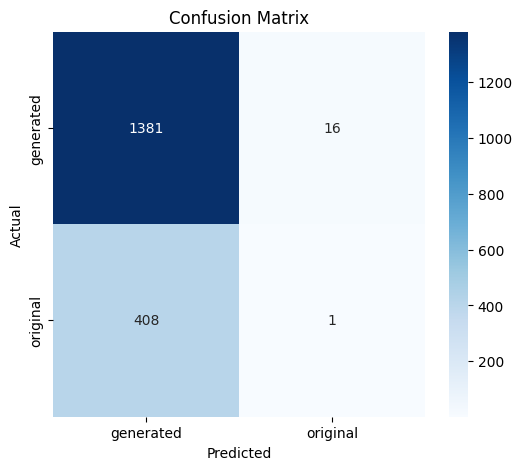

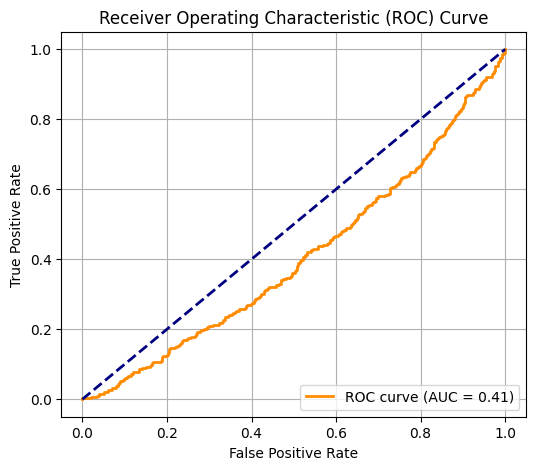

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model
results = model.evaluate(
    test_generator,
    steps=len(test_generator),
    verbose=1,
    return_dict=True
)
print(results)

# Get ground truth and predictions
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Class labels
labels = list(test_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
